<div align="center", class="alert alert-block alert-success">
    <h1>Deep Learning Project</h1>
    <h2>Matryoshka Autoencoder U-Net (MAE-UNet)</h2>
    <h3>Training on Initial Data Inputs for Generating More Annotated Data</h3>
    <h4><i>By Ariba Khan (17270) and Dr. Sawera Hanif (29413)</i></h4>
</div>

### Introduction

In this notebook, we will begin by training a **Matryoshka Autoencoder U-Net (MAE-UNet) model** using an initial dataset of **1,014** images and their corresponding masks.

The goal is to enable the model to learn to accurately segment the left ventricle of the heart, an essential task in medical image analysis. Once trained, the model will generate additional annotated data, which can then be used for further model development, including left ventricle segmentation in echocardiogram videos.

Alongside model training, we will track key performance metrics such as training time, memory usage, and CPU/GPU resource consumption to optimize the process and ensure efficient utilization of computational resources.

#### Importing Necessary Libraries

In [14]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=33a0b5456adbcab304b1f811f037e46476b9e68b31b042d7634b1306718d3b35
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [15]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import time
import psutil
import GPUtil
from threading import Thread
from sklearn.metrics import accuracy_score
import zipfile
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#### Dataset Class Function

In [3]:
class LeftVentricleSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing input images.
            mask_dir (str): Path to the directory containing segmentation masks.
            transform (callable, optional): Optional transformation for the images.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir) # listing all image filenames in the image directory

        # defining mask transformation to create binary masks
        self.mask_transform = transforms.Compose([
            transforms.ToTensor(), # converting mask to tensor
            transforms.Lambda(lambda x: torch.where(
                x == 1/255, # binary threshold for mask pixels
                torch.tensor(1.0), # if pixel value matches 1/255, set to 1.0
                torch.tensor(0.0) # else, set to 0.0
            ))
        ])

    def __len__(self):
        """
        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            dict: A dictionary containing:
                - 'image': The input image tensor.
                - 'mask': The corresponding binary mask tensor.
        """
        # getting image and mask filenames
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name.replace(".png", "_mask.png"))

        # loading image and mask
        image = Image.open(image_path).convert('RGB') # ensuring image is in RGB format
        mask = Image.open(mask_path)

        # applying transformations to the image
        if self.transform:
            image = self.transform(image)

        # applying binary mask transformation
        mask = self.mask_transform(mask)

        return {'image': image, 'mask': mask}

#### Creating Data Loaders

In [4]:
image_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

dataset = LeftVentricleSegmentationDataset(
    image_dir='/kaggle/input/echonetd-images-and-masks/Initial Images',
    mask_dir='/kaggle/input/echonetd-images-and-masks/Initial Masks',
    transform=image_transform)

In [5]:
# note: we have 1014 images (and their respective masks) in total

train_size = 1000
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [6]:
# inspecting a single batch of data from the training data loader

batch = next(iter(train_loader))

images = batch['image']
masks = batch['mask']

print(f"Shape of input images batch: {images.shape}")  # (Batch size, Channels, Height, Width)
print(f"Shape of masks batch: {masks.shape}")          # (Batch size, Channels, Height, Width)

Shape of input images batch: torch.Size([32, 3, 112, 112])
Shape of masks batch: torch.Size([32, 1, 112, 112])


*Note:* The images (still frames of echocardiograms) have three channels (RGB) whereas the masks have 1 channel (greyscale).

#### Matryoshka Autoencoder U-Net (MAE-UNet) Model

> *The code and structure for this U-Net model was referenced from the Matryoshka Representation Learning (Papers with Code), Medium's 'Using Autoencoders to Reduce Embedding Dimensions with Matryoshka Representation Learning' article, and DataCamp's course 'Deep Learning for Images with PyTorch'.*

In [7]:
class MatryoshkaAE(nn.Module):
    def __init__(self, input_shape, nesting_dims):
        super(MatryoshkaAE, self).__init__()
        self.encoders = nn.ModuleList()
        channels, height, width = input_shape

        for dim in nesting_dims:
            self.encoders.append(
                nn.Sequential(
                    nn.Conv2d(channels, dim, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2)  # Downsampling by a factor of 2
                )
            )
            channels = dim  # Update channels for the next layer

    def forward(self, x):
        outputs = []
        for encoder in self.encoders:
            x = encoder(x)
            outputs.append(x)

        return outputs

In [23]:
class UNetWithMAE(nn.Module):
    def __init__(self, mae, out_channels):
        super(UNetWithMAE, self).__init__()
        self.mae = mae

        # Decoder blocks
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(128, 64)

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64, 32)

        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(32, 16)

        # Final output layer
        self.out_conv = nn.Conv2d(16, out_channels, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # Upsample to 112x112

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder (MatryoshkaAE)
        encoder_outputs = self.mae(x)

        # Decoder
        x = self.upconv3(encoder_outputs[-1])  # Start from the smallest latent feature map
        x = torch.cat([x, encoder_outputs[-2]], dim=1)  # Skip connection
        x = self.dec3(x)

        x = self.upconv2(x)
        x = torch.cat([x, encoder_outputs[-3]], dim=1)  # Skip connection
        x = self.dec2(x)

        x = self.upconv1(x)
        x = torch.cat([x, encoder_outputs[-4]], dim=1)  # Skip connection
        x = self.dec1(x)

        # Upsample to match target size (112x112)
        x = self.upsample(x)  # Upsample the feature map to match the target size

        return self.out_conv(x)  # Final output layer

mae = MatryoshkaAE(input_shape, nesting_dims).to(device)  # Move MAE model to the device
unet = UNetWithMAE(mae, out_channels=1).to(device)  # Move UNet model to the device

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

unet = unet.to(device)  # Make sure the model is on the correct device

# Example input (batch of 4 images)
example_input = torch.randn(4, 3, 112, 112).to(device)  # Move the input to the GPU

# Forward pass
output = unet(example_input)

# Print the output shape
print(f"Output shape: {output.shape}")  # Expected: [4, 1, 112, 112]

Output shape: torch.Size([4, 1, 112, 112])


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device
unet = unet.to(device)

# Example forward pass with input tensor moved to the same device
example_input = torch.randn(4, 3, 112, 112).to(device)  # Move input to GPU if available

# Forward pass
output = unet(example_input)

# Print the output shape
print(f"Output shape: {output.shape}")  # Expected: [4, 1, 112, 112]

Output shape: torch.Size([4, 1, 112, 112])


In [28]:
# Assuming 'device' is set to 'cuda' if a GPU is available or 'cpu' otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the device (GPU or CPU)
unet = unet.to(device)

# Inspecting a single batch of data from the training data loader
batch = next(iter(train_loader))

# Extracting images and masks
images = batch['image']
masks = batch['mask']

# Move the images and masks to the same device as the model
images = images.to(device)
masks = masks.to(device)

# Print the shapes of the images and masks after moving them to the device
print(f"Shape of input images batch: {images.shape}")  # (Batch size, Channels, Height, Width)
print(f"Shape of masks batch: {masks.shape}")          # (Batch size, Channels, Height, Width)

Shape of input images batch: torch.Size([32, 3, 112, 112])
Shape of masks batch: torch.Size([32, 1, 112, 112])


In [30]:
# Check the device of the model by looking at one of its parameters
model_device = next(unet.parameters()).device
print(f"Model is on device: {model_device}")

# Check the device of the input images and masks
print(f"Input images are on device: {images.device}")
print(f"Masks are on device: {masks.device}")

# Forward pass to get output
output = unet(images)

# Check the device of the output
print(f"Output is on device: {output.device}")

Model is on device: cuda:0
Input images are on device: cuda:0
Masks are on device: cuda:0
Output is on device: cuda:0


### Function to Monitor Resources

In [31]:
def monitor_resources_continuously(log):
    process = psutil.Process()
    while log["running"]:
        try:
            # get memory usage
            memory_info = process.memory_info()
            memory_mb = memory_info.rss / (1024 * 1024) # convert to MB
            
            # get CPU usage
            cpu_percent = psutil.cpu_percent(interval=0.1) # short interval for real-time updates
            
            # get GPU usage
            gpus = GPUtil.getGPUs()
            gpu_percent = gpus[0].memoryUtil * 100 if gpus else 0 # GPU memory usage
            
            # logging the usage
            log["memory"].append(memory_mb)
            log["cpu"].append(cpu_percent)
            log["gpu"].append(gpu_percent)
        except Exception as e:
            print(f"Resource monitoring error: {e}")
        time.sleep(0.5)  # log every 0.5 seconds

### Training Loop

In [32]:
# logging setup for resource monitoring
log = {"memory": [], "cpu": [], "gpu": [], "running": True}

# starting resource monitoring in a separate thread
monitor_thread = Thread(target=monitor_resources_continuously, args=(log,))
monitor_thread.start()

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize MatryoshkaAE and UNetWithMAE
input_shape = (3, 112, 112)  # Input shape (channels, height, width)
nesting_dims = [16, 32, 64, 128]  # Encoder channel dimensions

# Instantiate the MatryoshkaAE model
mae = MatryoshkaAE(input_shape, nesting_dims).to(device)

# Instantiate the UNetWithMAE model with the MAE encoder and binary segmentation output
unet = UNetWithMAE(mae, out_channels=1).to(device)  # Move model to the GPU

# Define the loss function (binary cross-entropy with logits) and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)  # Loss function on GPU
optimizer = optim.Adam(unet.parameters(), lr=1e-4)

# Assuming the input is a batch of images and the target is binary (segmentation mask)
input_batch = torch.randn(32, 3, 112, 112).to(device)  # Example input (batch_size=32)
target_batch = torch.randint(0, 2, (32, 1, 112, 112)).float().to(device)  # Example binary target

# Forward pass example
output_batch = unet(input_batch)

# Calculate loss
loss = criterion(output_batch, target_batch)

# Backward pass and optimization
optimizer.zero_grad()  # Clear previous gradients
loss.backward()  # Backpropagate the loss
optimizer.step()  # Update model parameters


print(f"Loss: {loss.item()}")

Loss: 0.6986117959022522


In [36]:
start_time = time.time()

num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    unet.train() # training mode
    train_loss = 0.0

    for batch in train_loader:
        # loading data to device
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        # forward pass
        outputs = unet(images)
        loss = criterion(outputs, masks)

        # backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # validation loop
    unet.eval() # validation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            outputs = unet(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# stopping resource monitoring after training is complete
log["running"] = False
monitor_thread.join()

# calculating training time
end_time = time.time()
training_time = end_time - start_time

Epoch [1/50], Train Loss: 0.1806, Val Loss: 0.1920
Epoch [2/50], Train Loss: 0.1762, Val Loss: 0.1881
Epoch [3/50], Train Loss: 0.1727, Val Loss: 0.1941
Epoch [4/50], Train Loss: 0.1693, Val Loss: 0.1890
Epoch [5/50], Train Loss: 0.1650, Val Loss: 0.1796
Epoch [6/50], Train Loss: 0.1615, Val Loss: 0.1806
Epoch [7/50], Train Loss: 0.1579, Val Loss: 0.1759
Epoch [8/50], Train Loss: 0.1550, Val Loss: 0.1902
Epoch [9/50], Train Loss: 0.1513, Val Loss: 0.1781
Epoch [10/50], Train Loss: 0.1505, Val Loss: 0.1663
Epoch [11/50], Train Loss: 0.1456, Val Loss: 0.1652
Epoch [12/50], Train Loss: 0.1421, Val Loss: 0.1786
Epoch [13/50], Train Loss: 0.1389, Val Loss: 0.1572
Epoch [14/50], Train Loss: 0.1359, Val Loss: 0.1776
Epoch [15/50], Train Loss: 0.1333, Val Loss: 0.1557
Epoch [16/50], Train Loss: 0.1304, Val Loss: 0.1529
Epoch [17/50], Train Loss: 0.1283, Val Loss: 0.1824
Epoch [18/50], Train Loss: 0.1255, Val Loss: 0.1647
Epoch [19/50], Train Loss: 0.1224, Val Loss: 0.1438
Epoch [20/50], Train 

In [37]:
# saving learned weights

torch.save(unet.state_dict(), "mae_unet.pth")

#### Calculating Resources Consumed

In [38]:
if len(log["memory"]) > 0:
    avg_memory = sum(log["memory"]) / len(log["memory"])
    peak_memory = max(log["memory"])
else:
    avg_memory = peak_memory = 0

if len(log["cpu"]) > 0:
    avg_cpu = sum(log["cpu"]) / len(log["cpu"])
    peak_cpu = max(log["cpu"])
else:
    avg_cpu = peak_cpu = 0

if len(log["gpu"]) > 0:
    avg_gpu = sum(log["gpu"]) / len(log["gpu"])
    peak_gpu = max(log["gpu"])
else:
    avg_gpu = peak_gpu = 0

print(f"Training Time: {training_time:.2f} seconds")
print(f"Average Memory Usage: {avg_memory:.2f} MB")
print(f"Peak Memory Usage: {peak_memory:.2f} MB")
print(f"Average CPU Usage: {avg_cpu:.2f}%")
print(f"Peak CPU Usage: {peak_cpu:.2f}%")
print(f"Average GPU Usage: {avg_gpu:.2f}%")
print(f"Peak GPU Usage: {peak_gpu:.2f}%")

Training Time: 161.88 seconds
Average Memory Usage: 1124.50 MB
Peak Memory Usage: 1135.36 MB
Average CPU Usage: 25.35%
Peak CPU Usage: 90.00%
Average GPU Usage: 5.18%
Peak GPU Usage: 5.19%


#### Visualizing Training Performance

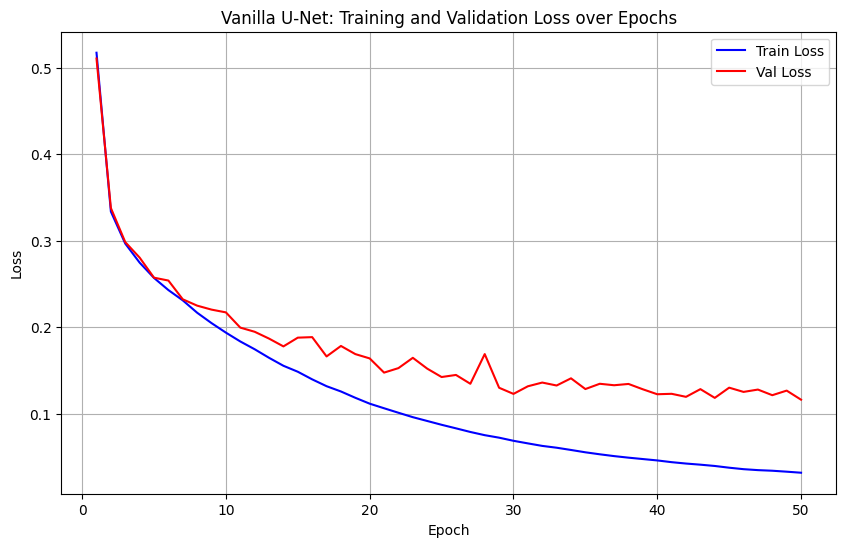

In [40]:
epochs = list(range(1, 51))

train_losses = [
    0.5173, 0.3337, 0.2967, 0.2747, 0.2570, 0.2430, 0.2311, 0.2168, 0.2048, 0.1938,
    0.1836, 0.1746, 0.1647, 0.1555, 0.1486, 0.1398, 0.1319, 0.1258, 0.1185, 0.1117,
    0.1064, 0.1012, 0.0961, 0.0917, 0.0873, 0.0832, 0.0790, 0.0753, 0.0724, 0.0688,
    0.0658, 0.0629, 0.0608, 0.0582, 0.0555, 0.0532, 0.0511, 0.0493, 0.0477, 0.0461,
    0.0441, 0.0425, 0.0412, 0.0397, 0.0377, 0.0360, 0.0349, 0.0342, 0.0331, 0.0319
]

val_losses = [
    0.5106, 0.3378, 0.2984, 0.2805, 0.2573, 0.2540, 0.2323, 0.2250, 0.2204, 0.2172,
    0.1996, 0.1948, 0.1869, 0.1779, 0.1880, 0.1886, 0.1663, 0.1784, 0.1690, 0.1640,
    0.1476, 0.1528, 0.1647, 0.1522, 0.1425, 0.1449, 0.1347, 0.1690, 0.1301, 0.1230,
    0.1318, 0.1361, 0.1327, 0.1410, 0.1286, 0.1347, 0.1330, 0.1345, 0.1283, 0.1226,
    0.1231, 0.1196, 0.1285, 0.1184, 0.1302, 0.1253, 0.1280, 0.1215, 0.1268, 0.1163
]

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')

plt.title('Vanilla U-Net: Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Inference Over Test Data

We will now evaluate the model in inference mode, generating segmentation masks for the test data, masking the regions of interest, and calculating evaluation metrics to assess its performance.

In [41]:
# defining all needed functions

# 1. IoU (Intersection Over Union)
def calculate_iou(preds, masks):
    preds = preds > 0.5
    masks = masks > 0.5

    preds = preds.to(torch.bool)
    masks = masks.to(torch.bool)
    
    intersection = torch.sum(preds & masks, dim=(1, 2, 3))
    union = torch.sum(preds | masks, dim=(1, 2, 3))
    iou = intersection / (union + 1e-6)
    return iou.mean().item()

# 2. Dice Coefficient 
def calculate_dice(preds, masks):
    preds = preds > 0.5
    masks = masks > 0.5

    preds = preds.to(torch.bool)
    masks = masks.to(torch.bool)

    intersection = torch.sum(preds & masks, dim=(1, 2, 3))
    dice = (2 * intersection + 1e-6) / (torch.sum(preds, dim=(1, 2, 3)).float() + torch.sum(masks, dim=(1, 2, 3)).float() + 1e-6)
    
    return dice.mean().item()

# 3. Pixel Accuracy
def calculate_pixel_accuracy(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)
    accuracy = accuracy_score(masks.cpu().numpy(), preds.cpu().numpy())
    return accuracy

# 5. Inference, Visualization and Evaluation Loop
def infer_and_visualize(model, dataloader, device):
    model.eval()
    total_iou = 0
    total_dice = 0
    total_pixel_acc = 0
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)  # ground truth masks

            # Get model predictions
            outputs = model(images)  # output logits
            preds = torch.sigmoid(outputs) > 0.5  # converting logits to binary predictions
            
            # converting predictions and masks to CPU and numpy for visualization
            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()

            # visualizing all samples in the batch
            for i in range(len(images)):
                fig, axes = plt.subplots(1, 4, figsize=(15, 10))
                axes[0].imshow(images_np[i].transpose(1, 2, 0))  # displaying original image (RGB)
                axes[0].set_title('Original Image')
                axes[0].axis('off')

                axes[1].imshow(masks_np[i][0], cmap='gray')  # ground truth mask (grayscale)
                axes[1].set_title('Ground Truth Mask')
                axes[1].axis('off')

                axes[2].imshow(preds_np[i][0], cmap='gray')  # predicted mask (grayscale)
                axes[2].set_title('Predicted Mask')
                axes[2].axis('off')

                # displaying segmented portion (highlighted heart region)
                segmented = images_np[i].transpose(1, 2, 0) * np.expand_dims(preds_np[i][0], axis=-1)  # applying generated mask to image
                axes[3].imshow(segmented)  # segmented image
                axes[3].set_title('Left Ventricle Segmentation')
                axes[3].axis('off')

                plt.show()

                # calculating metrics for this image
                iou = calculate_iou(preds[i:i+1], masks[i:i+1])  # IoU for this image
                dice = calculate_dice(preds[i:i+1], masks[i:i+1])  # Dice for this image
                pixel_acc = calculate_pixel_accuracy(preds[i:i+1], masks[i:i+1])  # Pixel Accuracy for this image

                total_iou += iou
                total_dice += dice
                total_pixel_acc += pixel_acc
                num_batches += 1

    # average metrics over all batches
    mean_iou = total_iou / num_batches
    mean_dice = total_dice / num_batches
    mean_pixel_acc = total_pixel_acc / num_batches

    print(f"Mean IoU: {mean_iou * 100:.2f}%")
    print(f"Mean Dice Coefficient: {mean_dice * 100:.2f}%")
    print(f"Mean Pixel Accuracy: {mean_pixel_acc * 100:.2f}%")

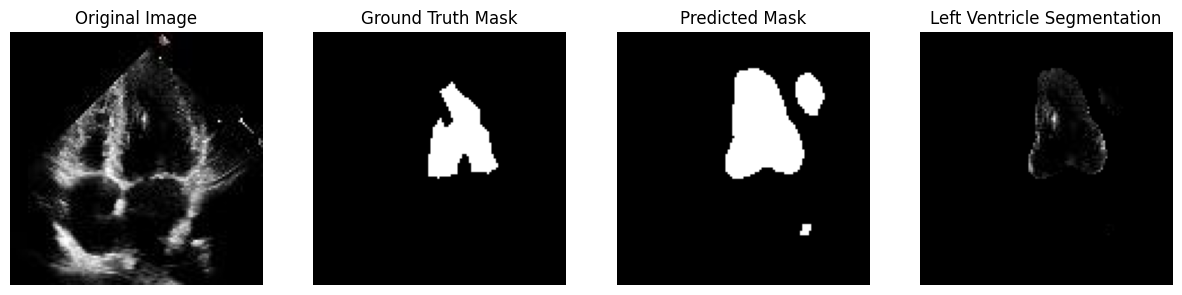

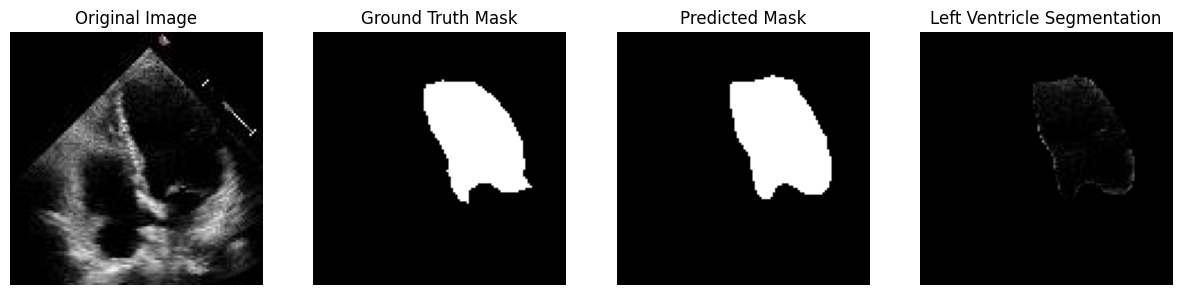

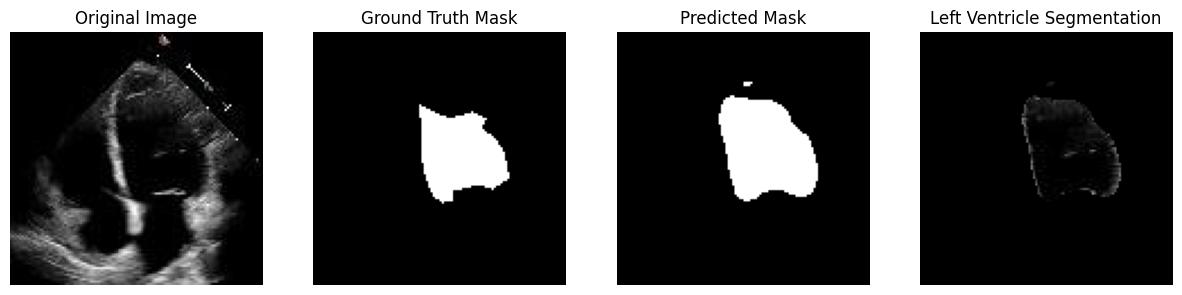

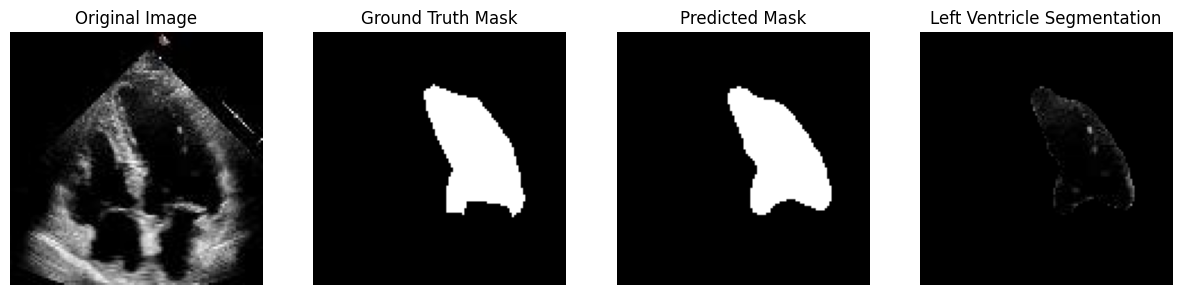

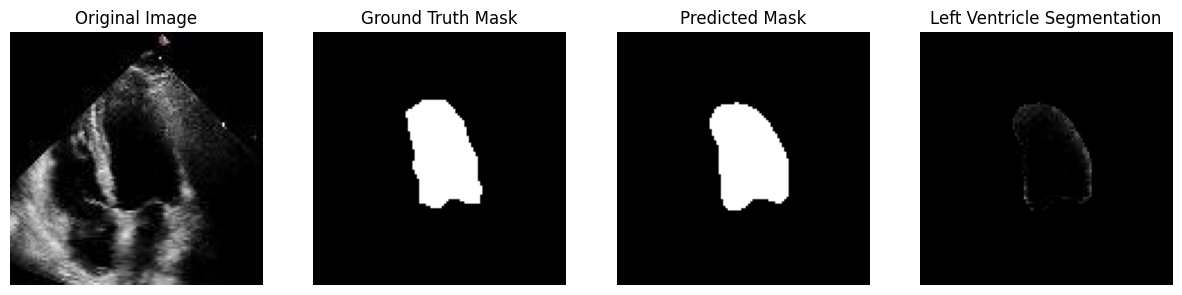

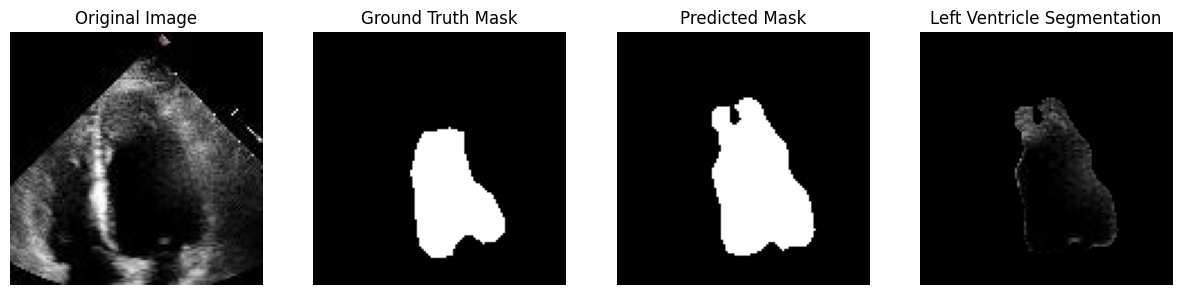

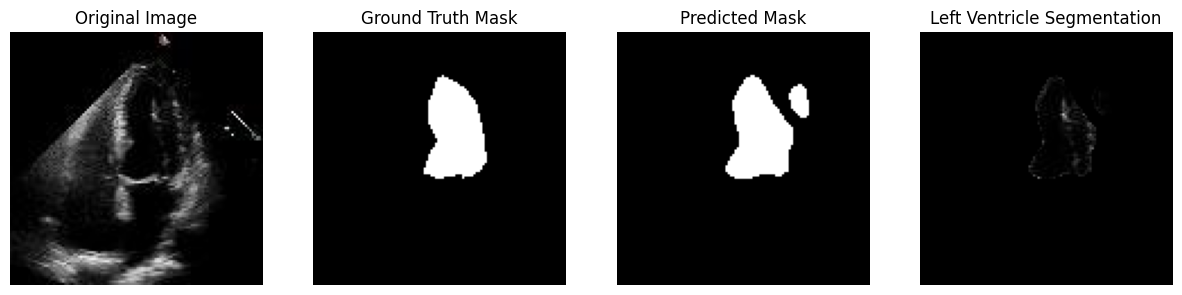

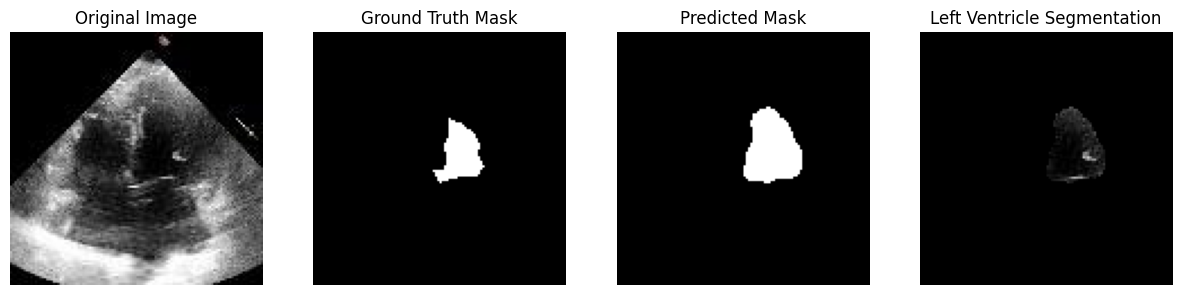

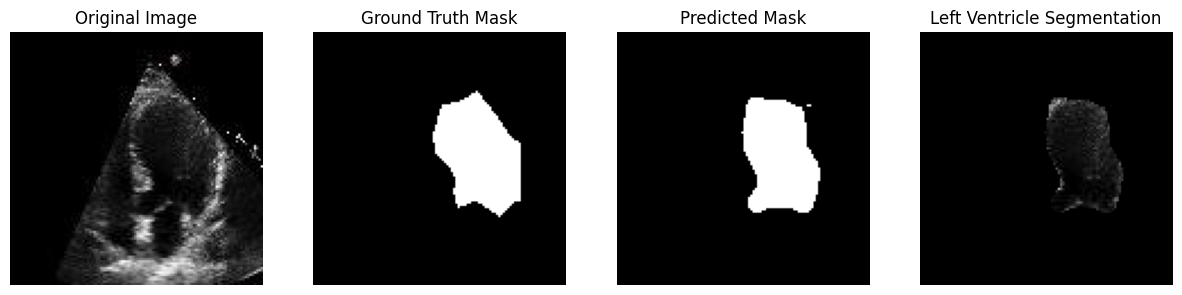

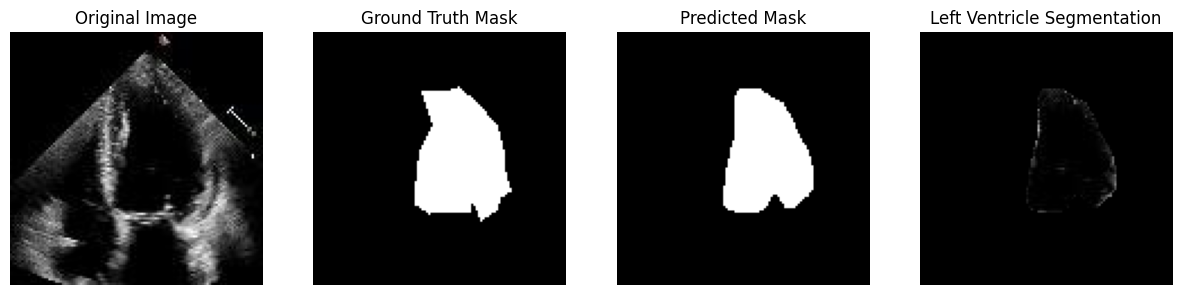

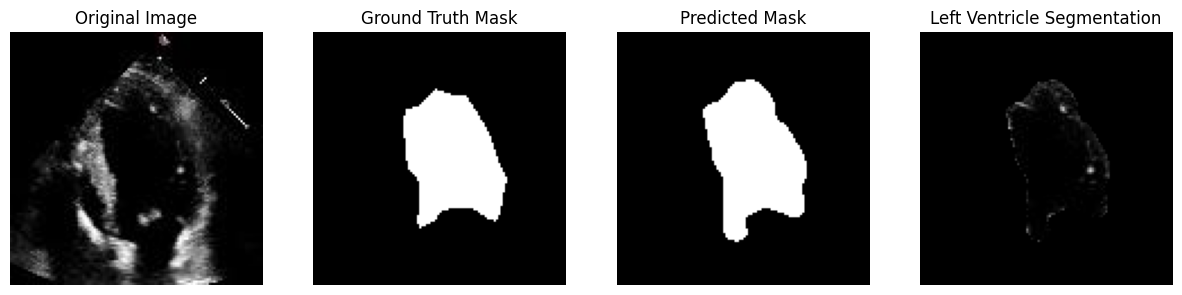

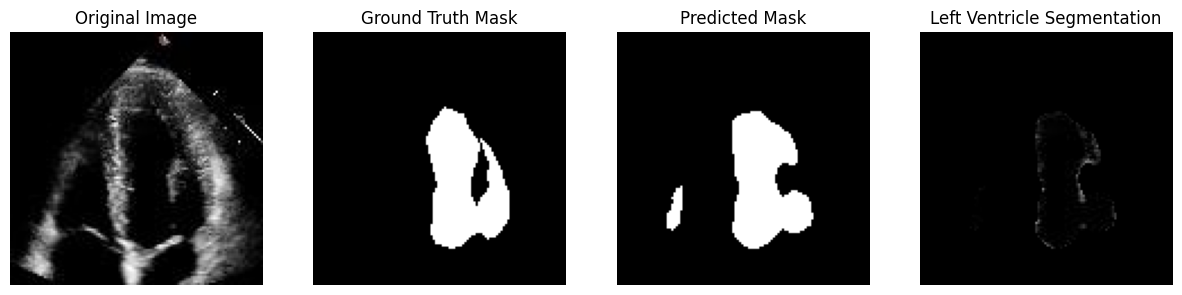

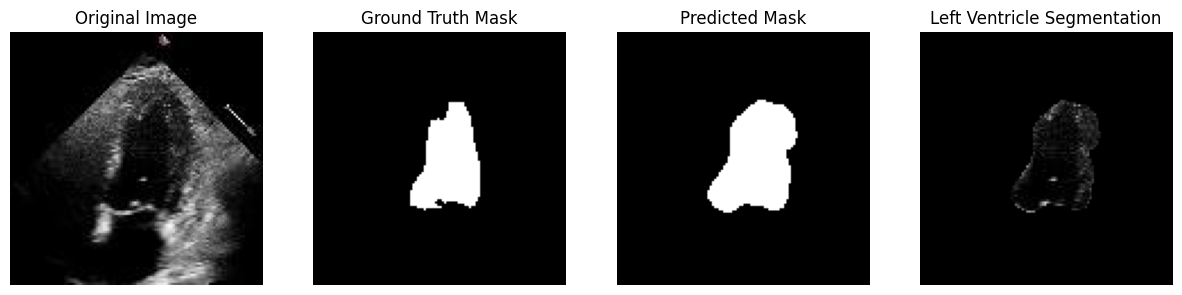

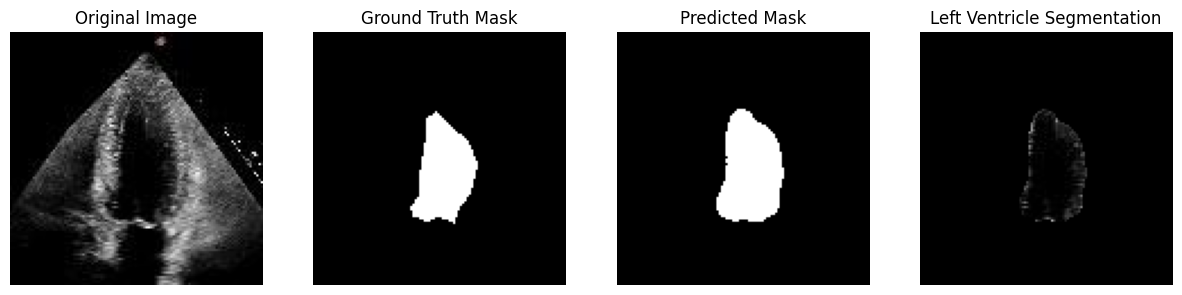

Mean IoU: 77.68%
Mean Dice Coefficient: 86.91%
Mean Pixel Accuracy: 97.46%


In [43]:
# running the inference loop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
infer_and_visualize(unet, test_loader, device)

### Generating Masks for Remaining Dataset

In [44]:
unet.load_state_dict(torch.load('/kaggle/input/mae-unet-for-lv-segmentation/pytorch/default/1/mae_unet.pth'))

<All keys matched successfully>

In [45]:
class RemainingSegmentationDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing input images.
            transform (callable, optional): Optional transformation for the images.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)  # listing all image filenames in the image directory

    def __len__(self):
        """
        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing:
                - 'image': The input image tensor.
                - 'name': The image name (for saving masks later).
        """
        # getting image filename and path
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)

        # loading image and ensuring it's in RGB format
        image = Image.open(image_path).convert('RGB')

        # applying transformations to the image
        if self.transform:
            image = self.transform(image)

        return {'image': image, 'name': image_name}

In [48]:
transform = transforms.Compose([
    transforms.Resize((112, 112)), # maintaining size of the original images
    transforms.ToTensor(), # converting images to pytorch tensors
])

image_dir = "/kaggle/input/remaining-inputs" # path for remaining dataset images
output_dir = "/kaggle/working/generated_masks"  # output folder for generated masks

os.makedirs(output_dir, exist_ok=True)

In [49]:
dataset = RemainingSegmentationDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet.to(device)

unet.eval()

UNetWithMAE(
  (mae): MatryoshkaAE(
    (encoders): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (upconv3): ConvTranspose2d(128, 64, kernel_size=(2, 

In [52]:
print("Generating masks...")
for batch in tqdm(dataloader):
    image = batch['image'].to(device)
    name = os.path.splitext(batch['name'][0])[0] + '_mask.png'

    # predicting the mask
    with torch.no_grad():
        output = unet(image)
        output = torch.sigmoid(output)  # applying sigmoid to get probabilities
        mask = (output > 0.5).float()  # thresholding to get binary mask

    # converting mask to numpy and save as PNG
    mask_np = mask.squeeze().cpu().numpy()
    mask_np = (mask_np * 255).astype(np.uint8)  # converting to 0-255 for saving as image
    mask_image = Image.fromarray(mask_np)
    mask_image.save(os.path.join(output_dir, name))

Generating masks...


100%|██████████| 8882/8882 [00:58<00:00, 150.69it/s]


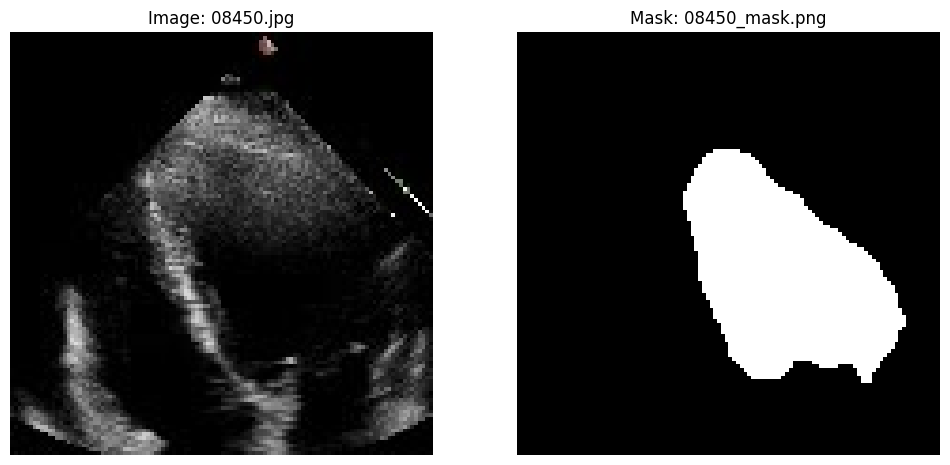

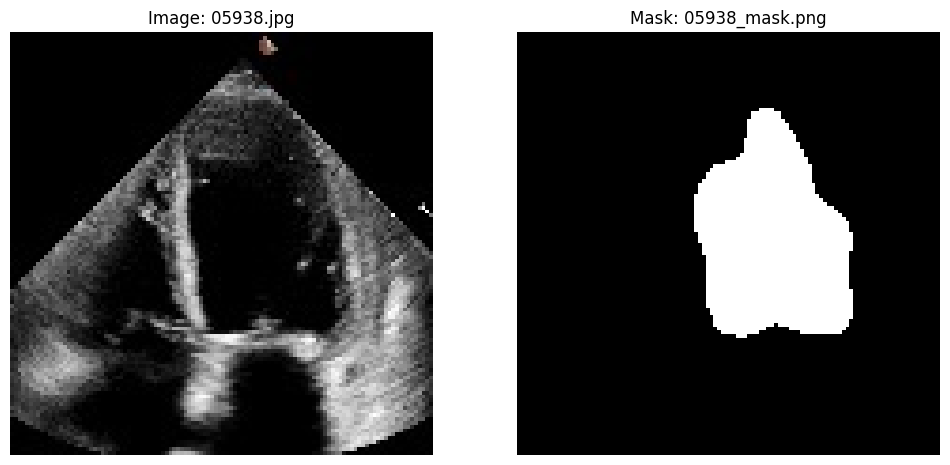

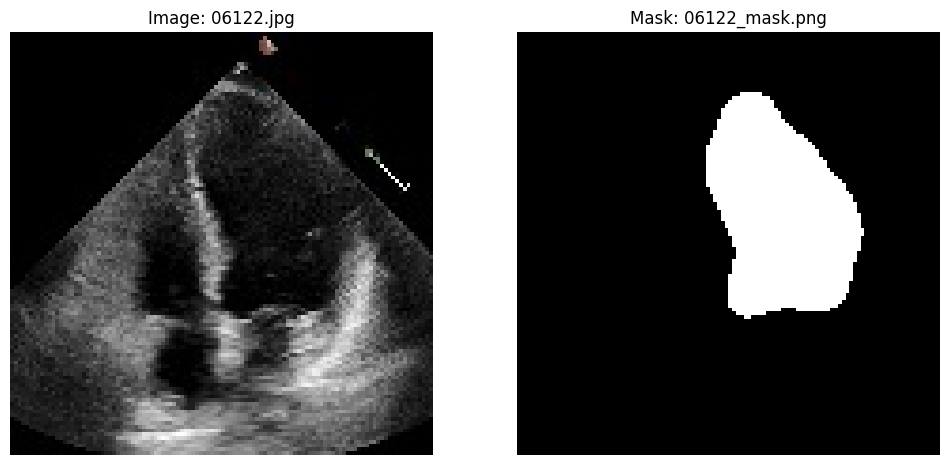

In [53]:
sample_images = os.listdir(image_dir)[:3]

for image_name in sample_images:
    image_path = os.path.join(image_dir, image_name)
    
    mask_name = os.path.splitext(image_name)[0] + '_mask.png'
    mask_path = os.path.join(output_dir, mask_name)
    
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(image)
    axes[0].set_title(f"Image: {image_name}")
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f"Mask: {mask_name}")
    axes[1].axis('off')
    
    plt.show()

### Zipping All Generated Masks

In [55]:
zip_dir = '/kaggle/working/'

zip_filename = "generated_masks_by_mae_unet.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file),
                       arcname=os.path.relpath(os.path.join(root, file), zip_dir))

print(f"Masks saved and zipped to {zip_filename}")

Masks saved and zipped to generated_masks_by_mae_unet.zip
